# Fetch Datathon: Similarity Search

Prepared and presented by Chen Zhang

## 1. Data Cleaning

The first step is data cleaning. One of the key steps in processing language data is to remove noise so that the machine can more easily detect the patterns in the data. 

Text data contains a lot of noise, this takes the form of special characters. All of which are difficult for computers to understand if they are present in the data. We need to, therefore, process the data to remove these elements.

Additionally, it is also important to apply some attention to the casing of words. If we include both upper case and lower case versions of the same words then the computer will see these as different entities, even though they may be the same.

One example is shown in the snapshot of the offer_retailer.csv file below. Note that some items starts with a column character, and the 2nd and 3rd row has only difference with a capital letter 'L'. 

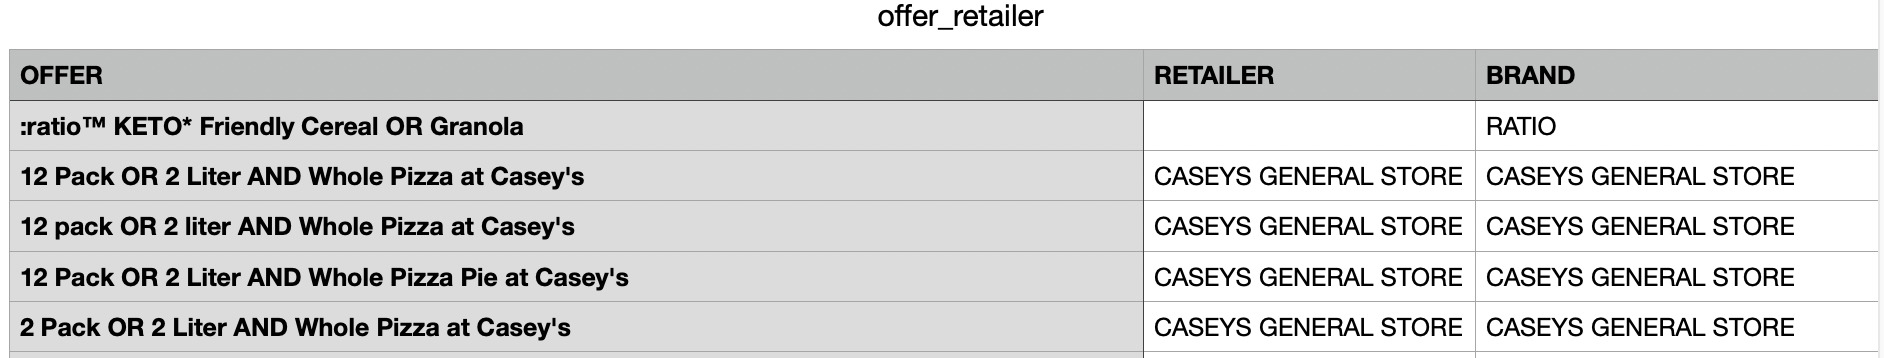

The code below performs these steps. To keep a track of the changes we are making to the text I have put the clean text into a new column. The output is shown below the code.



In [1]:
import numpy as np
import pandas as pd
import re

def clean(file): 
    # change to lower case
    df = pd.read_csv(file, dtype = str)
    for col in df.columns.values: 
        df[col] = df[col].str.lower()
    
    # remove special characters in the offer column
    if file == 'offer_retailer.csv': 
        for index, row in df.iterrows():
            txt = row['OFFER']
            df.loc[index, "OFFER"] = re.sub(r"[^a-z0-9 ]", "", txt)
    # remove duplicate rows
        df.drop_duplicates(subset=['OFFER'], inplace = True)
    return df

The three datasets are shown below, after cleaning. Note that a few lines in the offer_retailer file are removed due to duplication. The missing values in the 'Retailer' column are filled with empty strings. The some columns are also re-named for the purpose of future joining. 

In [5]:
# Offer_brand table
offer = clean('offer_retailer.csv')
offer.replace(np.nan,'',regex=True, inplace=True)
print(offer.head())
print(offer.shape)

                                               OFFER            RETAILER  \
0       spend 50 on a fullpriced new club membership           sams club   
1           beyond meat plantbased products spend 25                       
2           good humor viennetta frozen vanilla cake                       
3  butterball select varieties spend 10 at dillon...  dillons food store   
4  gatorade fast twitch 12ounce 12 pack at amazon...              amazon   

         BRAND  
0    sams club  
1  beyond meat  
2   good humor  
3   butterball  
4     gatorade  
(369, 3)


In [6]:
brand = clean('brand_category.csv')
brand.rename(columns={"BRAND_BELONGS_TO_CATEGORY": "CATEGORY"}, inplace=True)
for index, row in brand.iterrows():
    txt1 = row['CATEGORY']
    brand.loc[index, "CATEGORY"] = re.sub(r"[^a-z0-9 ]", "", txt1)
print(brand.head())
print(brand.shape)

              BRAND          CATEGORY RECEIPTS
0  caseys gen store  tobacco products  2950931
1  caseys gen store            mature  2859240
2            equate      hair removal   893268
3         palmolive        bath  body   542562
4              dawn        bath  body   301844
(9906, 3)


In [10]:
category = clean('categories.csv')
category.rename(columns={"PRODUCT_CATEGORY": "CATEGORY", 
                      "IS_CHILD_CATEGORY_TO": "PARENT_CATEGORY"}, inplace=True)
for index, row in category.iterrows():
    txt1 = row['CATEGORY']
    category.loc[index, "CATEGORY"] = re.sub(r"[^a-z0-9 ]", "", txt1)
    txt2 = row['PARENT_CATEGORY']
    category.loc[index, "PARENT_CATEGORY"] = re.sub(r"[^a-z0-9 ]", "", txt2)

category.drop(columns=['CATEGORY_ID'], inplace = True)

print(category.head())
print(category.shape)

                     CATEGORY   PARENT_CATEGORY
0             red pasta sauce       pasta sauce
1  alfredo  white pasta sauce       pasta sauce
2             cooking  baking            pantry
3            packaged seafood            pantry
4            feminine hygeine  health  wellness
(118, 2)


## 2. Table merge

I'd like to join all table into one major table for better handling. 

In [11]:
# join the brand and category table, using pandas merge function which is equal to SQL inner join
brand_cat = brand.merge(category, right_on = ['CATEGORY'], left_on = ['CATEGORY'])

print(f'After joining the category (shape {category.shape}) and brand table (shape {brand.shape}), the output has shape of {brand_cat.shape}')
print(brand_cat.head())

After joining the category (shape (118, 2)) and brand table (shape (9906, 3)), the output has shape of (9906, 4)
               BRAND          CATEGORY RECEIPTS   PARENT_CATEGORY
0   caseys gen store  tobacco products  2950931            mature
1  rj reynolds vapor  tobacco products       21            mature
2   caseys gen store            mature  2859240            mature
3             equate      hair removal   893268  health  wellness
4           barbasol      hair removal   283926  health  wellness


In [12]:
full = offer.merge(brand_cat, right_on = ['BRAND'], left_on = ['BRAND'])

# rearrange columns
cols = ['OFFER', 'RETAILER', 'BRAND', 'CATEGORY', 'PARENT_CATEGORY', 'RECEIPTS']
full = full[cols]
print(full)
print(full.shape)

                                                 OFFER       RETAILER  \
0             beyond meat plantbased products spend 25                  
1             beyond meat plantbased products spend 25                  
2             beyond meat plantbased products spend 25                  
3    beyond steak plantbased seared tips 10 ounce a...         target   
4    beyond steak plantbased seared tips 10 ounce a...         target   
..                                                 ...            ...   
745  breyers reeses ice cream select varieties at g...  martins foods   
746  breyers reeses ice cream select varieties at g...  martins foods   
747                        jack links select varieties                  
748           simply organic seasoning mixes or spices                  
749           simply organic seasoning mixes or spices                  

              BRAND                CATEGORY PARENT_CATEGORY RECEIPTS  
0       beyond meat           packaged meat         

It's worth noting that the major table has duplicate rows for some categories that belongs to more than one parent category. One example is frozen pizza is under both 'frozen' and 'pantry' parent_category, which makes sense. With the above major table ready, I will move forward and seek for input similarity search. 

## 3. Similarity Search based on fuzzy string

A few critieria including ratio, partial ratio, token sort ratio, token set ratio, and partial token sort ratio, are being tested. One example is shown below using 'meat' as the input. In the category column, there are a few categories that contains word 'meat'. 

In [64]:
from thefuzz import fuzz

name = "meat"
similarity = category.copy()
partialRatio, ratio, tokenSortRatio, tokenSetRatio, partialTokenSortRatio = [], [], [], [], []

# for criteria in ['Ratio', 'Partial Ratio', 'Token Sort Ratio', 'Token Set Ratio', 'Partial Token Set Ratio']: 
#     print(similarity['CATEGORY'].nlargest(10, criteria))

for index, row in similarity.iterrows():
    val = row['CATEGORY']
#     full_name = "Kurtis K D Pykes"
    a = fuzz.partial_ratio(name, val)
    b = fuzz.ratio(name, val)
    c = fuzz.token_sort_ratio(name, val)
    d = fuzz.token_set_ratio(name, val)
    e = fuzz.partial_token_sort_ratio(name, val)
    partialRatio.append(a)
    ratio.append(b)
    tokenSortRatio.append(c)
    tokenSetRatio.append(d)
    partialTokenSortRatio.append(e)
similarity['Partial Ratio'] = partialRatio
similarity['Ratio'] = ratio
similarity['Token Sort Ratio'] = tokenSortRatio
similarity['Token Set Ratio'] = tokenSetRatio
similarity['Partial Token Set Ratio'] = partialTokenSortRatio

for criteria in ['Ratio', 'Partial Ratio', 'Token Sort Ratio', 'Token Set Ratio', 'Partial Token Set Ratio']: 
    print(f'Top 10 matched category using {criteria}')
    print(similarity.nlargest(10, criteria)[['CATEGORY', criteria]])
    print()

Top 10 matched category using Ratio
            CATEGORY  Ratio
112           mature     60
52               tea     57
90     packaged meat     47
6              cream     44
51             bread     44
71             water     44
23        condiments     43
72   plantbased meat     42
74       fresh pasta     40
92            makeup     40

Top 10 matched category using Partial Ratio
                       CATEGORY  Partial Ratio
47            jerky  dried meat            100
72              plantbased meat            100
90                packaged meat            100
105      frozen plantbased meat            100
16   meal replacement beverages             75
19                 frozen meals             75
23                   condiments             75
24        packaged meals  sides             75
35                sexual health             75
36               malt beverages             75

Top 10 matched category using Token Sort Ratio
              CATEGORY  Token Sort Ratio
112  

Based on the result above, partial ratio and partial token set ratio outperformed others. partial token set ratio is selected for further testing. Now the method can output the top N matched category and the corresponding offer. 

In [40]:
# now test a few inputs for the search
queries = ['meat', 'frozen meat', 'coffee', 'caffe', 'fruitss', 'doughnuts', 'ricecereal', 'bath']
N = 20
pd.set_option("display.max_colwidth", 35)
for q in queries: 
    similarity = full.copy()
    partialTokenSortRatio = []

    for index, row in similarity.iterrows():
        val = row['CATEGORY']
        partialTokenSortRatio.append(fuzz.partial_token_sort_ratio(q, val))
    similarity['Sim Score'] = partialTokenSortRatio

    print(f'Top {N} offers by matching category {q}')
    print(similarity.nlargest(N, 'Sim Score')[['OFFER', 'CATEGORY', 'Sim Score']])
    print()

Top 20 offers by matching category frozen meat
                                  OFFER                CATEGORY  Sim Score
2    beyond meat plantbased products...  frozen plantbased meat        100
5    beyond steak plantbased seared ...  frozen plantbased meat        100
8    beyond steak plantbased seared ...  frozen plantbased meat        100
11   beyond steak plantbased seared ...  frozen plantbased meat        100
14   beyond steak plantbased seared ...  frozen plantbased meat        100
17   beyond meat plantbased products...  frozen plantbased meat        100
20   beyond meat plantbased products...  frozen plantbased meat        100
107  any general mills products buy ...            frozen meals         91
122  general mills products select b...            frozen meals         91
137  general mills products select b...            frozen meals         91
152  general mills products select v...            frozen meals         91
205         gortons at select retailers            fr

## 4. Similarity Search using transfomer

Text/Sentence similarity is one of the clearest examples of how powerful transformer models can be. Here the NLP solution will take some query text, process it to create an embeddings using pre-trained model, and compute the similarity between the query text and the target field (e.g. category column). A few well-established models are evaluated including 'all-MiniLM-L6-v2', 'all-mpnet-base-v2', 'all-distilroberta-v1', and 'bert-base-nli-mean-tokens'. 'bert-base-nli-mean-tokens' is selected due to robustness and high performance. 

'bert-base-nli-mean-tokens' is a sentence-transformers model that maps sentences & paragraphs to a 768 dimensional dense vector space and can be used for tasks like clustering or semantic search. Using 'meat' as an examplary query test for category search, the model clearly generates more meaningful results than the previous 

In [90]:
from sentence_transformers import SentenceTransformer
model_name = 'bert-base-nli-mean-tokens'
# model_name = 'all-MiniLM-L6-v2'
# model_name = 'all-mpnet-base-v2'

In [91]:
model = SentenceTransformer(model_name)

In [92]:
sentences = category['CATEGORY'].to_list()
# sentences

In [93]:
sentence_vecs = model.encode(sentences)

In [94]:
sentence_vecs

array([[-0.41283208,  0.19538327, -0.7930067 , ..., -0.17972049,
         0.6738818 ,  0.5252664 ],
       [-0.38252142,  0.27116126, -0.44621935, ..., -0.20450772,
         0.08800625,  0.83287764],
       [ 0.17573915,  0.8770489 ,  1.3612206 , ..., -0.0657338 ,
         0.25192803,  0.43508112],
       ...,
       [-0.51006913,  1.0867724 , -0.1981626 , ..., -0.18807282,
         0.77340156,  0.3120817 ],
       [-0.18643278,  0.87110186,  0.6632734 , ..., -0.37362155,
        -0.26959875,  0.02258943],
       [ 0.26655945,  0.2495401 ,  1.5600967 , ...,  0.7145732 ,
         0.29977995,  0.2982676 ]], dtype=float32)

In [95]:
sentence_vecs[0].shape

(768,)

In [49]:
from sklearn.metrics.pairwise import cosine_similarity

In [96]:
query = model.encode(['meat'])
print(query.shape)
cos = cosine_similarity(
    query, 
    sentence_vecs
)
similarity = category.copy()
similarity['Cosine'] = cos.reshape(-1, 1)

print(similarity.nlargest(20, 'Cosine')[['CATEGORY', 'Cosine']])

(1, 768)
                       CATEGORY    Cosine
90                packaged meat  0.899200
72              plantbased meat  0.810214
47            jerky  dried meat  0.733520
105      frozen plantbased meat  0.671159
115                 frozen beef  0.632474
62                 food storage  0.621770
73                         eggs  0.609283
84                 dog supplies  0.607903
114              frozen chicken  0.570397
23                   condiments  0.569826
86               prepared meals  0.569633
63                       cheese  0.568969
85                pickled goods  0.568233
24        packaged meals  sides  0.567027
30                  soup  broth  0.566426
64            frozen vegetables  0.564005
17                     pretzels  0.547607
16   meal replacement beverages  0.529368
113               frozen turkey  0.528729
51                        bread  0.522049
